In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import time

import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import os
os.chdir('/your/path/')

In [2]:
# Load processed DE PSD data and labels
data_de = []
data_psd = []
labels = []
num_channel = 32

for i in range(1, 33):
    feature = np.load("features_new/s{:02d}.npy".format(i), allow_pickle=True).item()
    psd = feature['psd_trial'] - feature['psd_baseline']
    de = feature['de_trial'] - feature['de_baseline']
    data_de.append(de)
    data_psd.append(psd)

    labels.append(feature['ratings'])

labels = np.concatenate(labels)
data_de = np.concatenate(data_de)
data_psd = np.concatenate(data_psd)

In [4]:
# The length of preprocessed data is only 58s, we need to pad it to 60s
def regulate_length(data):
    data = torch.reshape(data, (1280, num_channel, 5, 58, 4))
    data = torch.mean(data, dim=-1)
    zeros = torch.zeros((1280, num_channel, 5, 2), dtype=data.dtype, device=data.device)
    zeros[..., -2:] = data[..., -2:]
    data = torch.cat([data, zeros], dim=-1)
    print(data.shape)
    return data


padded_de = regulate_length(torch.from_numpy(data_de))
padded_psd = regulate_length(torch.from_numpy(data_psd))

print(padded_de.shape)
print(padded_psd.shape)

torch.Size([1280, 32, 5, 60])
torch.Size([1280, 32, 5, 60])
torch.Size([1280, 32, 5, 60])
torch.Size([1280, 32, 5, 60])


In [5]:

class MutualCrossAttention(nn.Module):
    def __init__(self, dropout):
        super(MutualCrossAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x1, x2):
        # Assign x1 and x2 to query and key
        query = x1
        key = x2
        d = query.shape[-1]

        # Basic attention mechanism formula to get intermediate output A
        scores = torch.bmm(query, key.transpose(1, 2)) / math.sqrt(d)
        output_A = torch.bmm(self.dropout(F.softmax(scores, dim=-1)), x2)
        # Basic attention mechanism formula to get intermediate output B
        scores = torch.bmm(key, query.transpose(1, 2)) / math.sqrt(d)
        output_B = torch.bmm(self.dropout(F.softmax(scores, dim=-1)), x1)

        # Make the summation of the two intermediate outputs
        output = output_A + output_B  # shape (1280, 32, 60)

        return output

In [6]:
bands_counter = []
bands_num = 5
# Dropout 0.3 for avoiding overfitting
attention_merge = MutualCrossAttention(0.3)

# The MCA is implemented for each band separately
for i in range(bands_num):
    single_de = padded_de[:, :, i, :]
    single_psd = padded_psd[:, :, i, :]
    band = attention_merge(single_de, single_psd)
    bands_counter.append(band)

mca_processed = torch.stack(bands_counter, dim=2)

In [ ]:
# For feature processed by MCA
selected_feature = np.array(mca_processed)

# For unprocessed Channel-Frequency-DE
# selected_feature = np.array(padded_de)

# For unprocessed Channel-PSD-Time
# selected_feature = np.array(padded_psd)

# For baseline element-wise summation of DE and PSD
# selected_feature = np.array(padded_de + padded_psd)

In [7]:
# normalize
x_min = selected_feature.min(axis=(1, 2), keepdims=True)
x_max = selected_feature.max(axis=(1, 2), keepdims=True)
mca_normal = (selected_feature-x_min)/(x_max-x_min)

print(mca_normal.shape)
print(type(mca_normal))

(1280, 32, 5, 60)
<class 'numpy.ndarray'>


In [8]:
# The result output every 3s, adjust the depth to control the output frequency
# Don't encourage to modify it cause you also need to adjust the model input size
depth = 3

mca_normal = np.array(mca_normal)
mca_reshape = np.split(mca_normal, 60/depth, axis=3)
mca_reshape = np.reshape(mca_reshape, [-1, 32, 5, depth])
print(mca_reshape.shape)

(25600, 32, 5, 3)


In [9]:
####################Dividing Line#############################################
#																			 #
# 	The preliminary of data is almost done, now we process the labels		 #
# 	and set up the model for training										 #
#																			 #
####################Dividing Line#############################################

In [ ]:
# load label
cols = ['valence', 'arousal', 'dominance', 'liking']
label_df = pd.DataFrame(labels, columns=cols)
print(label_df.shape)
label_df[label_df < 5] = 0
label_df[label_df >= 5] = 1

# Choose the target dimension you want to validate
# The default is valence, which performs the best in our study
label_val = label_df['valence'].astype(int).values
label_val = np.tile(label_val, int(60/depth))
print(label_val.shape)

final_dataset = []
final_labels = []
final_dataset = mca_reshape
final_labels = label_val

(1280, 4)


In [15]:
# divive train & test
x_train, x_test, y_train, y_test = train_test_split(final_dataset, final_labels, test_size=0.1, random_state=1, stratify=final_labels)
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

# Final shape check of the processed data
torch.set_default_dtype(torch.double)
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
x_train = x_train.unsqueeze(1)
x_test = x_test.unsqueeze(1)

print(x_train.shape)
print(x_test.shape)

torch.Size([23040, 1, 32, 5, 3])
torch.Size([2560, 1, 32, 5, 3])


In [13]:
# Customized 3D CNN model to adapt to the input shape
class cnn_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv11 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool3d(kernel_size=2, padding=(0, 1, 1))

        self.conv21 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool3d(kernel_size=2, padding=0)

        self.fc_layer = nn.Linear(64*8*1*1, 2)
        self.dropout_layer = nn.Dropout(p=0.3)

    def forward(self, xb):
        h1 = self.conv11(xb)
        h1 = self.conv12(h1)
        h1 = self.pool1(h1)
        h1 = F.relu(h1)

        h2 = self.conv21(h1)
        h2 = self.conv22(h2)
        h2 = self.pool2(h2)
        h2 = F.relu(h2)

        # Before the fully connected layer, we need to flatten the output
        flatten = h2.view(-1, 64*8*1*1)
        out = self.fc_layer(flatten)
        return out

In [14]:
# Set up the training function
def train_model(model, x_train, y_train, x_test, y_test, epochs=12, batch_size=32, lr=0.0002, weight_decay=1e-4):
    # Load the data
    train_dataset = TensorDataset(x_train, y_train)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size)

    # Initialization of the loss function
    loss_func = F.cross_entropy

    # Choose Adam as the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning rate scheduler. Reduce the learning rate by a factor of 0.2 every 10 epochs
    scheduler = StepLR(optimizer, step_size=10, gamma=0.2)

    # Training and testing accuracy
    train_a = list([])
    test_a = list([])

    # Set up the training loop
    print('batch size: %d, learning rate: %f, weight_decay: %f' % (batch_size, lr, weight_decay))
    for epoch in range(epochs):
        model.train()
        tic = time.time()
        acc_train = []
        for xb, yb in train_data_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_func(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc_train.append(pred.detach().argmax(1).eq(yb).float().mean().cpu().numpy())
        acc_train = np.mean(acc_train)
        scheduler.step()
        toc = time.time()

        with torch.no_grad():
            model.eval()
            y_pred = model(x_test.to(device))
            acc = y_pred.argmax(1).eq(y_test.to(device)).float().mean().cpu().numpy()

        train_a.append(acc_train)
        test_a.append(acc)
        print('Loss at epoch %d / %d : %f, train_acc: %f, test_acc: %f, running time: %d' % (epoch, epochs, loss.item(), acc_train, acc, toc-tic))

    # Plot the figure of accuracy variation
    plt.plot(train_a, 'y.-.')
    plt.plot(test_a, '.-.')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

Using 2 GPUs.


batch size: 32, learning rate: 0.000200, weight_decay: 0.000100
Loss at epoch 0 / 12 : 0.563636, train_acc: 0.606424, test_acc: 0.699609, running time: 40
Loss at epoch 1 / 12 : 0.262289, train_acc: 0.831944, test_acc: 0.922656, running time: 35
Loss at epoch 2 / 12 : 0.093491, train_acc: 0.958724, test_acc: 0.969531, running time: 35
Loss at epoch 3 / 12 : 0.070301, train_acc: 0.983724, test_acc: 0.981641, running time: 35
Loss at epoch 4 / 12 : 0.023076, train_acc: 0.992231, test_acc: 0.983984, running time: 35
Loss at epoch 5 / 12 : 0.019170, train_acc: 0.996615, test_acc: 0.987891, running time: 35
Loss at epoch 6 / 12 : 0.008321, train_acc: 0.998394, test_acc: 0.987500, running time: 35
Loss at epoch 7 / 12 : 0.013350, train_acc: 0.998221, test_acc: 0.980078, running time: 35
Loss at epoch 8 / 12 : 0.017358, train_acc: 0.995920, test_acc: 0.989844, running time: 35
Loss at epoch 9 / 12 : 0.002265, train_acc: 0.998741, test_acc: 0.993359, running time: 35
Loss at epoch 10 / 12 : 0.

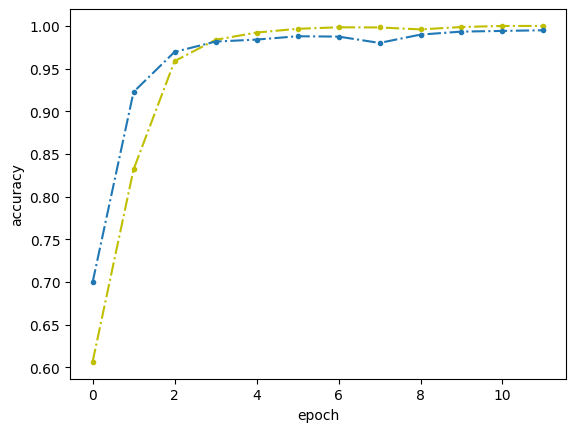

In [16]:
# Init the model
model = cnn_classifier()

# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(model)

device = torch.device('cuda')
model = model.to(device)
# Start training
train_model(model, x_train.view(-1, 1, 32, 5, depth).double(), y_train, x_test.view(-1, 1, 32, 5, depth).double(), y_test)

In [17]:
print(x_test.shape)
torch.save(x_test, "/your/path/MCA_valence_x.pth")  # data
torch.save(y_test, "/your/path/MCA_valence_y.pth")  # label

torch.Size([2560, 1, 32, 5, 3])


In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Predict process
with torch.no_grad():
    outputs = model(x_test.view(-1, 1, 32, 5, depth).double().to(device))
    predicted = outputs.argmax(1)

# Convert to numpy array
predicted = predicted.cpu().numpy()
y_test = y_test.cpu().numpy()

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(y_test, predicted)
conf_matrix = confusion_matrix(y_test, predicted)
conf_matrix_df = pd.DataFrame(conf_matrix,
                              index=['True: Low Valence', 'True: High Valence'],
                              columns=['Predict: Low Valence', 'Predict: High Valence'])

print(f"Model Accuracy: {accuracy}")
print(conf_matrix_df)

Model Accuracy: 0.994921875
                    Predict: Low Valence  Predict: High Valence
True: Low Valence                   1046                      6
True: High Valence                     7                   1501


In [20]:
# Save model
torch.save(model.state_dict(), "/your/path/MCA_valence.pth")